# Comparing _autodifferentiation_ & _finite differences_ in Metacalibration

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import autometacal

In [3]:
##Local settings
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import galsim
import tensorflow as tf

import tqdm

## Generate Data

In [4]:
seed = 31415
rng = np.random.RandomState(seed)

In [5]:
img_noise = 1.0e-6
psf_noise = img_noise/10
scale = 0.2
stamp_size = 64
psf_fwhm = 0.9
gal_hlr = 0.7

In [6]:
def make_data(N=1,
  psf_noise = 1.0e-5,
  img_noise = 1.0e-4,
  scale = 0.263,
  stamp_size = 51,
  psf_fwhm = 0.9,
  gal_hlr = 0.7,
  gal_g1 = [0],
  gal_g2 = [0]):
  
  gal_list = []
  psf_list = []
  
  for n in range(N):
    psf = galsim.Moffat(beta=2.5, 
                      fwhm=psf_fwhm)

    obj0 = galsim.Exponential(half_light_radius=gal_hlr).shear(g1=gal_g1[n],g2=gal_g2[n])
    obj = galsim.Convolve(psf, obj0)

    psf_image = psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array
    gal_image = obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array

    psf_image += rng.normal(scale=psf_noise, size=psf_image.shape)
    gal_image += rng.normal(scale=img_noise, size=gal_image.shape)
    gal_image = tf.convert_to_tensor(gal_image)
    psf_image = tf.convert_to_tensor(psf_image)
    gal_list.append(gal_image)
    psf_list.append(psf_image)
    del gal_image
    del psf_image
  gal_image_stack = tf.stack(gal_list)
  psf_image_stack = tf.stack(psf_list)
  return gal_image_stack, psf_image_stack

In [7]:
gal_images, psf_images = make_data(N=1,psf_noise = psf_noise,
                                  img_noise = img_noise,
                                  scale = scale,
                                  stamp_size = stamp_size,
                                  psf_fwhm = psf_fwhm,
                                  gal_hlr = gal_hlr,
                                  gal_g1 = [0.0,.01,-0.01],gal_g2=[0.0,.0,.01])

Text(0.5, 1.0, 'psf model')

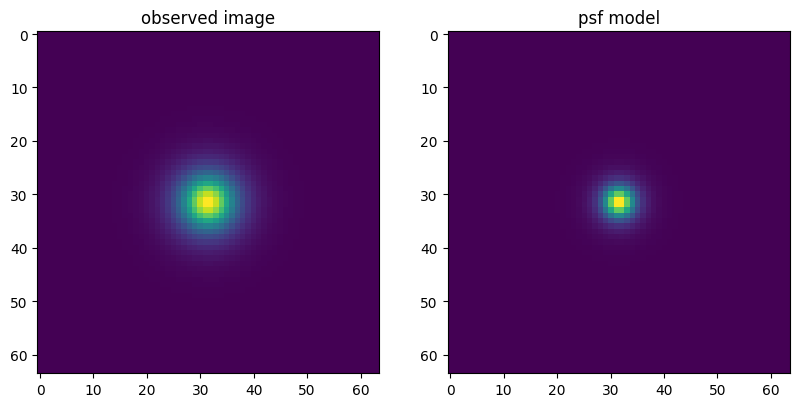

In [8]:
style.use('default')
figure(figsize=(15,5))
subplot(131)
imshow(gal_images[0]); title('observed image')
subplot(132)
imshow(psf_images[0]); title('psf model')


## Generate a 20% larger PSF for reconvolution.

In [9]:
reconv_psf = galsim.Moffat(beta=2.5, 
                    fwhm=psf_fwhm*1.2)
reconv_psf_image = tf.expand_dims(tf.convert_to_tensor(reconv_psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array),axis=0)

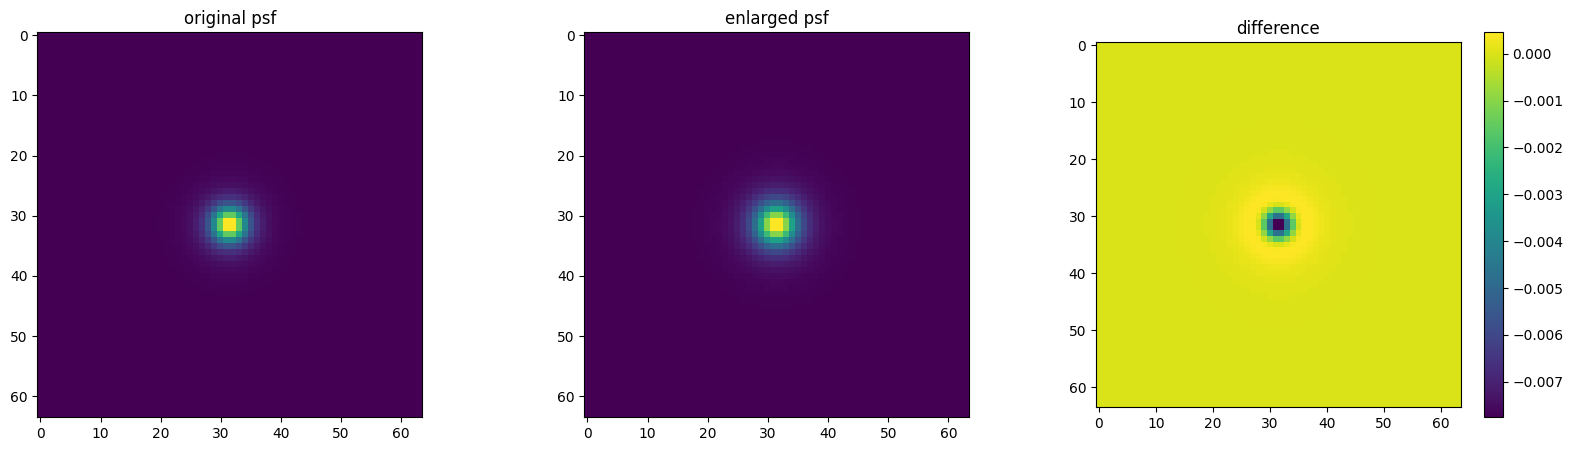

In [10]:
style.use('default')
figure(figsize=(20,5))
subplot(131)
imshow(psf_images[0]); title('original psf')
subplot(132)
imshow(reconv_psf_image[0]); title('enlarged psf')
subplot(133)
imshow(reconv_psf_image[0] - psf_images[0]); title('difference');colorbar()

## Test GalFlow Deconv/Reconv

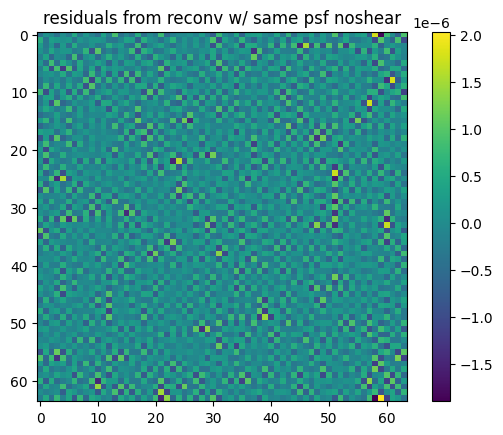

In [11]:
style.use('default')
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images[tf.newaxis,0],
                                       psf_images[tf.newaxis,0],[[0.0,0.0]])[0]-gal_images[0]);title('residuals from reconv w/ same psf noshear');colorbar()


## GalFlow vs GalSim

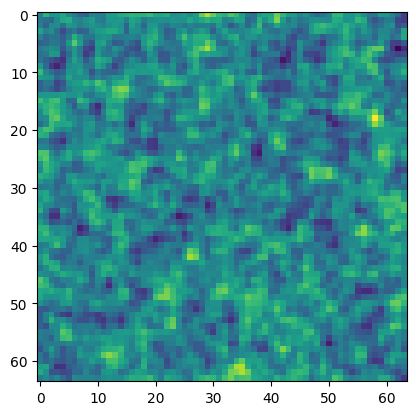

In [12]:
obj0 = galsim.Exponential(half_light_radius=gal_hlr)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=0.0,g2=0.0)])
counterfact = tf.expand_dims( tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array),axis=0)
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images[tf.newaxis,0],reconv_psf_image,[[0.0,0.0]])[0]-counterfact[0])

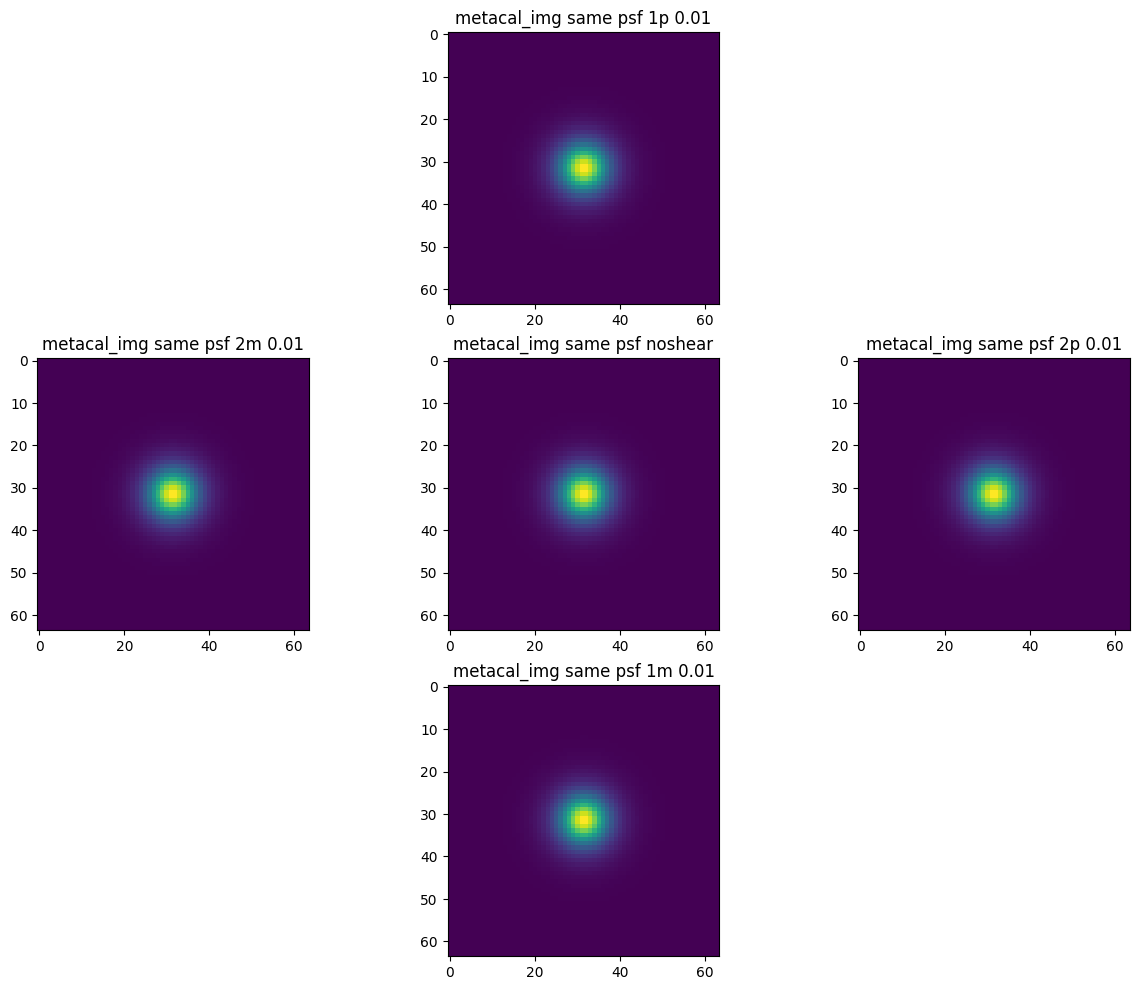

In [13]:
style.use('default')
figure(figsize=(15,12))

step = 0.01

subplot(335)
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[0.0,0.0]])[0])
title('metacal_img same psf noshear')

subplot(332)
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[step,0.0]])[0])
title(f'metacal_img same psf 1p {step}')

subplot(338)
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[-step,0.0]])[0])
title(f'metacal_img same psf 1m {step}')

subplot(336)
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[0.0,step]])[0])
title(f'metacal_img same psf 2p {step}')

subplot(334)
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[0.0,-step]])[0])
title(f'metacal_img same psf 2m {step}')
savefig('problems1.png',bbox_inches='tight')

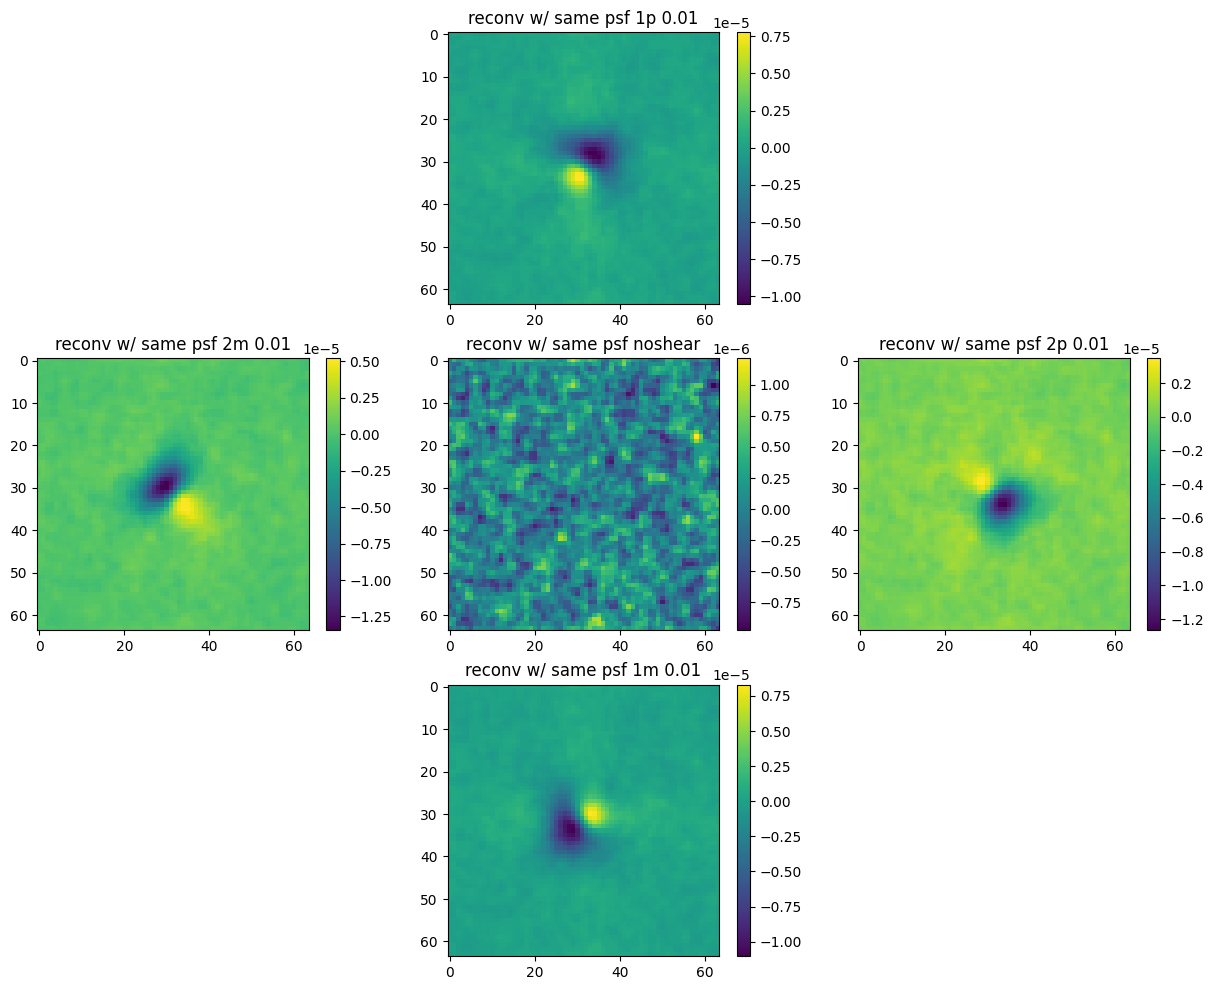

In [14]:
style.use('default')
figure(figsize=(15,12))

step = 0.01

subplot(335)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=0.0,g2=0.0)])
counterfact = tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, 
                                                         ny=stamp_size, 
                                                         scale=scale).array)[tf.newaxis]
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images,
                                       reconv_psf_image,[[0.0,0.0]])[0]-counterfact[0])
title('reconv w/ same psf noshear');colorbar()

subplot(332)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=step,g2=0.0)])
counterfact = tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, 
                                                         ny=stamp_size, 
                                                         scale=scale).array)[tf.newaxis]
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images,
                                       reconv_psf_image,[[step,0.0]])[0]-counterfact[0])
title(f'reconv w/ same psf 1p {step}');colorbar()

subplot(338)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=-step,g2=0.0)])
counterfact = tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, 
                                                         ny=stamp_size, 
                                                         scale=scale).array)[tf.newaxis]
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images,
                                       reconv_psf_image,[[-step,0.0]])[0]-counterfact[0])
title(f'reconv w/ same psf 1m {step}');colorbar()

subplot(336)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=0.0,g2=step)])
counterfact = tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, 
                                                         ny=stamp_size, 
                                                         scale=scale).array)[tf.newaxis]
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images,
                                       reconv_psf_image,[[0.0,step]])[0]-counterfact[0])
title(f'reconv w/ same psf 2p {step}');colorbar()

subplot(334)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=0.0,g2=-step)])
counterfact = tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, 
                                                         ny=stamp_size, 
                                                         scale=scale).array)[tf.newaxis]
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images,
                                       reconv_psf_image,[[0.0,-step]])[0]-counterfact[0])
title(f'reconv w/ same psf 2m {step}');colorbar()
savefig('problems2.png',bbox_inches='tight')

## Simple Ellipticity Measurements

In [15]:
def get_ellipticities(img):
  img_size = len(img[0])
  nx = img_size
  ny = img_size
  XX=np.zeros((nx,ny))
  XY=np.zeros((nx,ny))
  YY=np.zeros((nx,ny))
  w = np.zeros((nx,ny))
  sigma=img_size/3.
  
  for i in range(0,nx):
      x=0.5+i-(nx)/2.0
      for j in range(0,ny):
          y=0.5+j-(ny)/2.0
          XX[i,j]=x*x
          XY[i,j]=x*y
          YY[i,j]=y*y
          w[i,j]=np.exp(-((x) ** 2 + (y) ** 2) /
                                 (2 * sigma ** 2))
  

  norm = tf.reduce_sum(tf.reduce_sum(w*img, axis=-1), axis=-1)
  Q11 = tf.reduce_sum(tf.reduce_sum(w*img*YY, axis=-1), axis=-1)/norm
  Q12 = tf.reduce_sum(tf.reduce_sum(w*img*XY, axis=-1), axis=-1)/norm
  Q21 = Q12
  Q22 = tf.reduce_sum(tf.reduce_sum(w*img*XX, axis=-1), axis=-1)/norm
  q1 = Q11 - Q22
  q2 = 2*Q12
  T= Q11 + Q22  + 2*tf.sqrt(abs(Q11*Q22 - Q12**2))
  r = tf.stack([q1/T, q2/T], axis=-1)
  return r

In [16]:
get_ellipticities(gal_images)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-9.6885611e-05,  2.2189072e-04]], dtype=float32)>

In [17]:
g1, g2 = get_ellipticities(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[0.0,0.0]])[0])
print(f'0shear  g1={g1: .4f},  g2={g2: .4f}')
print('--------------------------------')
g1, g2 = get_ellipticities(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[0.05,0.0]])[0])
print(f'1p .05  g1={g1: .4f},  g2={g2: .4f}')
g1, g2 = get_ellipticities(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[-.05,0.0]])[0])
print(f'1m .05  g1={g1: .4f},  g2={g2: .4f}')
g1, g2 = get_ellipticities(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[0.0,0.05]])[0])
print(f'2p .05  g1={g1: .4f},  g2={g2: .4f}')
g1, g2 = get_ellipticities(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[0.0,-.05]])[0])
print(f'2m .05  g1={g1: .4f},  g2={g2: .4f}')

0shear  g1=-0.0001,  g2= 0.0001
--------------------------------
1p .05  g1= 0.0184,  g2= 0.0001
1m .05  g1=-0.0186,  g2= 0.0001
2p .05  g1=-0.0001,  g2= 0.0185
2m .05  g1=-0.0001,  g2=-0.0182


## Autodiff

In [18]:
e, R =autometacal.get_metacal_response(gal_images,psf_images,reconv_psf_image,get_ellipticities)
for e, R in zip(e,R):
  calibre=tf.linalg.inv(R) @ tf.reshape(e,[2,1])
  print(f'g1 = {calibre[0,0]: .5f}, g2 = {calibre[1,0]: .5f}')

g1 = -0.00024, g2 =  0.00036


In [19]:
e, R = autometacal.get_metacal_response(gal_images,psf_images,reconv_psf_image,get_ellipticities)
calibre0 = tf.linalg.inv(R[0]) @ tf.reshape(e[0],[2,1])

## Single image comparison between Autodiff and Finite diff

In [20]:
def get_metacal_response_finitediff(gal_image,psf_image,reconv_psf_image,step,method):
  
  img0s = autometacal.generate_mcal_image(gal_image,psf_image,reconv_psf_image,[[0,0]]) 
  img1p = autometacal.generate_mcal_image(gal_image,psf_image,reconv_psf_image,[[step,0]]) 
  img1m = autometacal.generate_mcal_image(gal_image,psf_image,reconv_psf_image,[[-step,0]]) 
  img2p = autometacal.generate_mcal_image(gal_image,psf_image,reconv_psf_image,[[0,step]]) 
  img2m = autometacal.generate_mcal_image(gal_image,psf_image,reconv_psf_image,[[0,-step]]) 
  
  g0s = get_ellipticities(img0s)
  g1p = get_ellipticities(img1p)
  g1m = get_ellipticities(img1m)
  g2p = get_ellipticities(img2p)
  g2m = get_ellipticities(img2m)
  
  d11 = (g1p[:,0]-g1m[:,0])/(2*step)
  d21 = (g1p[:,1]-g1m[:,1])/(2*step) 
  d12 = (g2p[:,0]-g2m[:,0])/(2*step)
  d22 = (g2p[:,1]-g2m[:,1])/(2*step)#problem
 
  R = np.array([[d11,d21],
                [d12,d22]]).T
  return g0s, R
  
e_f, R_f =get_metacal_response_finitediff(gal_image=abs(gal_images),
                                          psf_image=psf_images,
                                          reconv_psf_image=reconv_psf_image,
                                          step=0.01,
                                          method=get_ellipticities)

for e_f, R_f in zip(e_f,R_f):
  calibre_f=tf.linalg.inv(R_f) @ tf.reshape(e_f,[2,1])
  #print(f'g1 = {calibre_f[0,0]: .5f}, g2 = {calibre_f[1,0]: .5f}')
  #print(f'e = {np.sqrt(sum(calibre_f**2)): .5f}')

In [21]:
np.array([[[1,11,111],[2,22,222]],
          [[3,33,333],[4,44,444]]])

array([[[  1,  11, 111],
        [  2,  22, 222]],

       [[  3,  33, 333],
        [  4,  44, 444]]])

In [22]:
np.array([[[1,11,111],[3,33,333]],
          [[2,22,222],[4,44,444]]]).T

array([[[  1,   2],
        [  3,   4]],

       [[ 11,  22],
        [ 33,  44]],

       [[111, 222],
        [333, 444]]])

In [23]:
steps = np.logspace(-5,0,100)
ef_list = []
R11f_list = [] 
R12f_list = []
R21f_list = []
R22f_list = []
for step in steps:
  
  e_f, R_f=get_metacal_response_finitediff(gal_images[tf.newaxis,0],psf_images[tf.newaxis,0],reconv_psf_image,step,get_ellipticities)
  R11f_list.append(R_f[0,0,0])
  R12f_list.append(R_f[0,0,1])
  R21f_list.append(R_f[0,1,0])
  R22f_list.append(R_f[0,1,1])
  try:
    calibre_f=tf.linalg.inv(R_f) @ tf.reshape(e_f,[2,1])
    ef_list.append(np.sqrt(sum(calibre_f**2)))
    
  except:
    ef_list.append(np.nan)
    print('Ops!')

Ops!


In [24]:
e = np.sqrt(sum(calibre0**2))

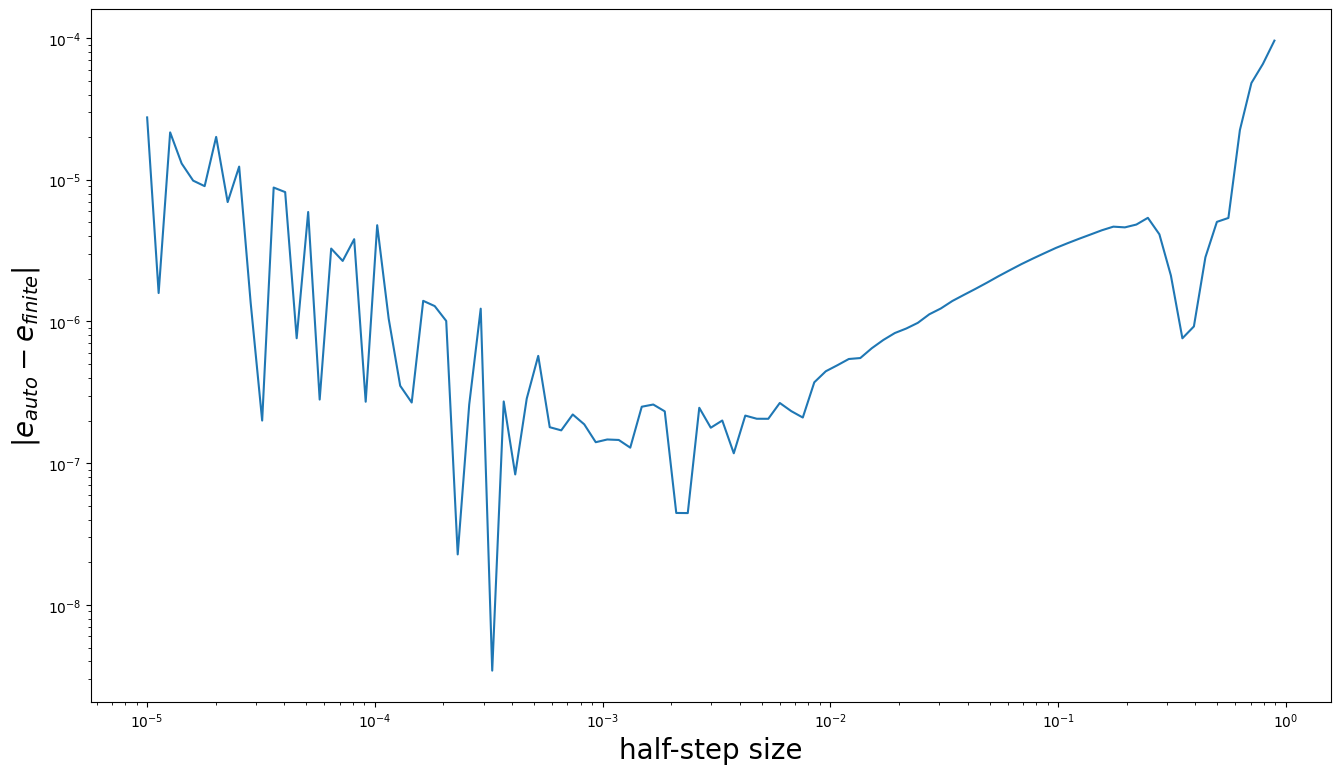

In [25]:
figure(figsize=(16,9))
plot(steps,abs(e-np.array(ef_list)) )
xscale('log')
yscale('log')
ylabel('$|e_{auto} - e_{finite}|$',fontsize=20)
xlabel('half-step size',fontsize=20)
savefig(f'autofinite{time.time()}.jpeg',bbox_inches='tight')

In [26]:
R11 = R[0,0,0]
R12 = R[0,0,1]
R21 = R[0,1,0]
R22 = R[0,1,1]

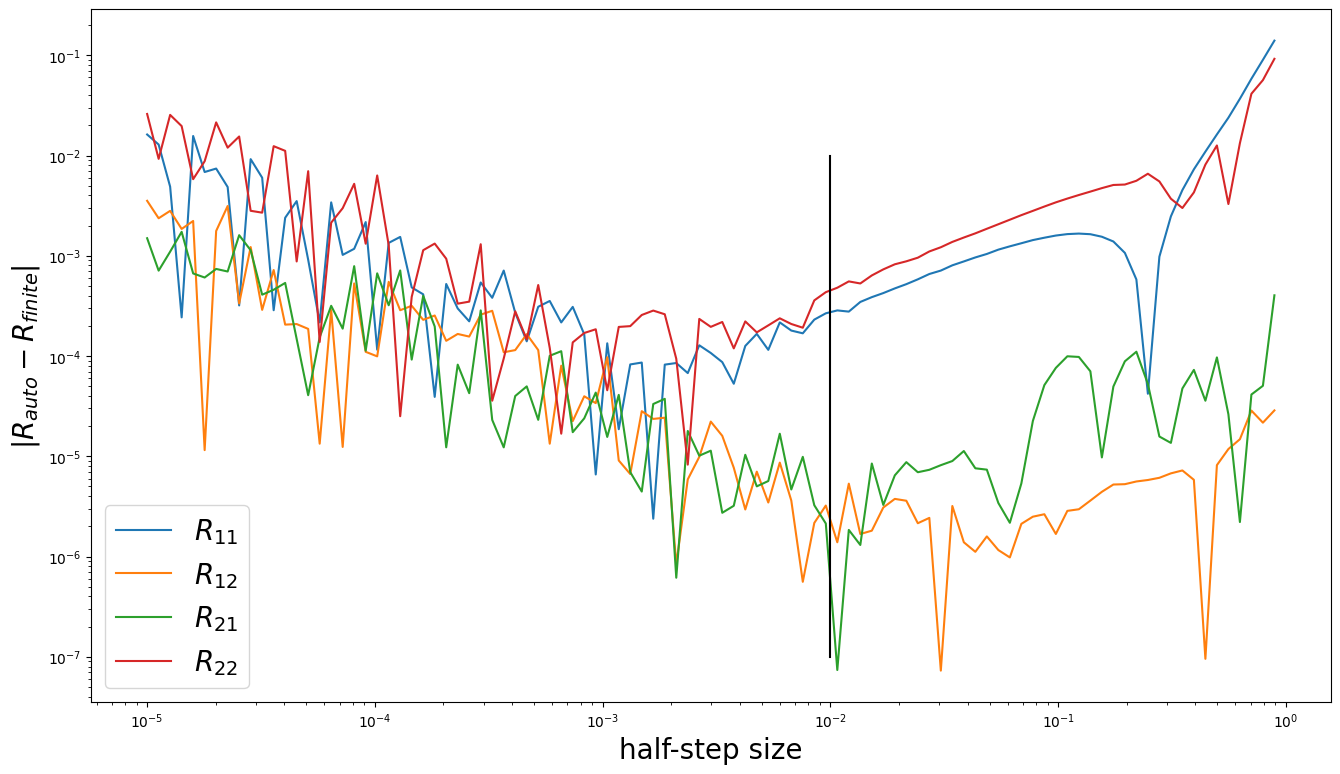

In [27]:
figure(figsize=(16,9))
plot(steps,abs(R11-np.array(R11f_list)),label="$R_{11}$" )
plot(steps,abs(R12-np.array(R12f_list)),label="$R_{12}$" )
plot(steps,abs(R21-np.array(R21f_list)),label="$R_{21}$" )
plot(steps,abs(R22-np.array(R22f_list)),label="$R_{22}$" )
plot([1e-2,1e-2],[1e-7,1e-2],'k-')
xscale('log')
yscale('log')
#ylim([1.5e-4,3e-4])
ylabel('$|R_{auto}-R_{finite}|$',fontsize=20)
xlabel('half-step size',fontsize=20)
legend(fontsize=20)
savefig(f'autofinite_response_log.jpeg',bbox_inches='tight')

## Galaxy Batches

In [28]:
from scipy.stats import truncnorm

In [29]:
g_list = []
i=0
gmax=.7
gscale = .2
gloc=0
while i<1000 :
  a, b = (-gmax - gloc) / gscale, (gmax - gloc) / gscale
  g1=g2=1
  #select ellipticities, ensure g<=1
  while g1**2+g2**2>1:
    g1 = truncnorm.rvs(a, b, loc=gloc, scale=gscale)
    g2 = truncnorm.rvs(a, b, loc=gloc, scale=gscale)
    i+=1
  g_list.append([g1,g2])
garray = np.array(g_list)

In [30]:

gal_images, psf_images = make_data(N=1000,
                                  psf_noise = psf_noise,
                                  img_noise = 1*img_noise,
                                  scale = scale,
                                  stamp_size = stamp_size,
                                  psf_fwhm = psf_fwhm,
                                  gal_hlr = gal_hlr,
                                  gal_g1=garray.T[0],gal_g2=garray.T[1])

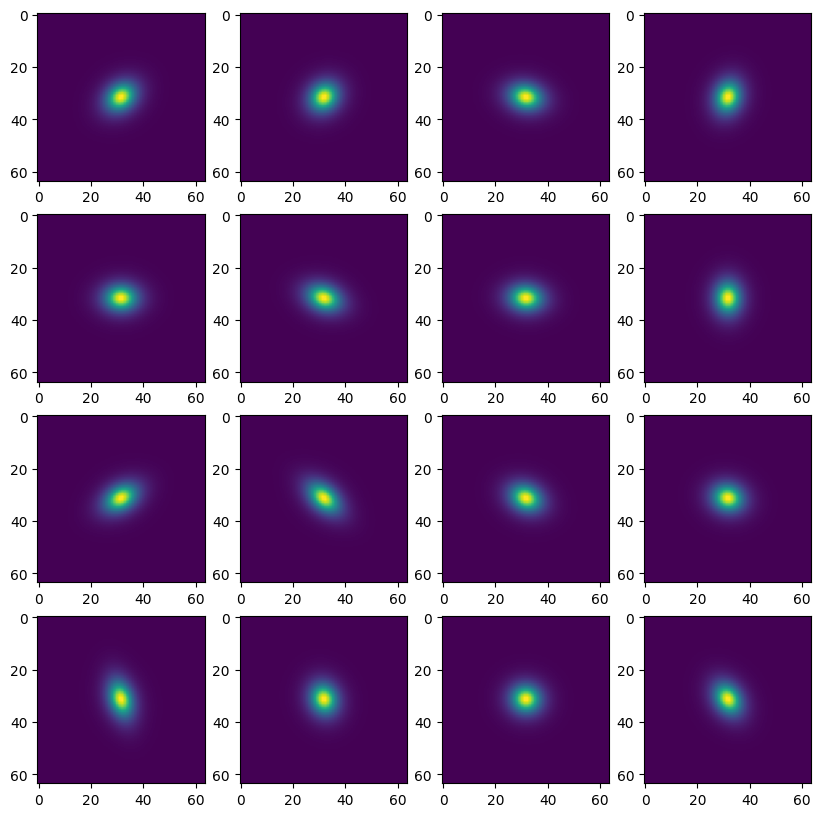

In [31]:
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i])

In [32]:
e_auto, R_auto = autometacal.get_metacal_response(gal_images,psf_images,reconv_psf_image,get_ellipticities)
calibre_f=tf.linalg.inv(R_auto[:]) @ tf.reshape(e_auto,[-1,2,1])

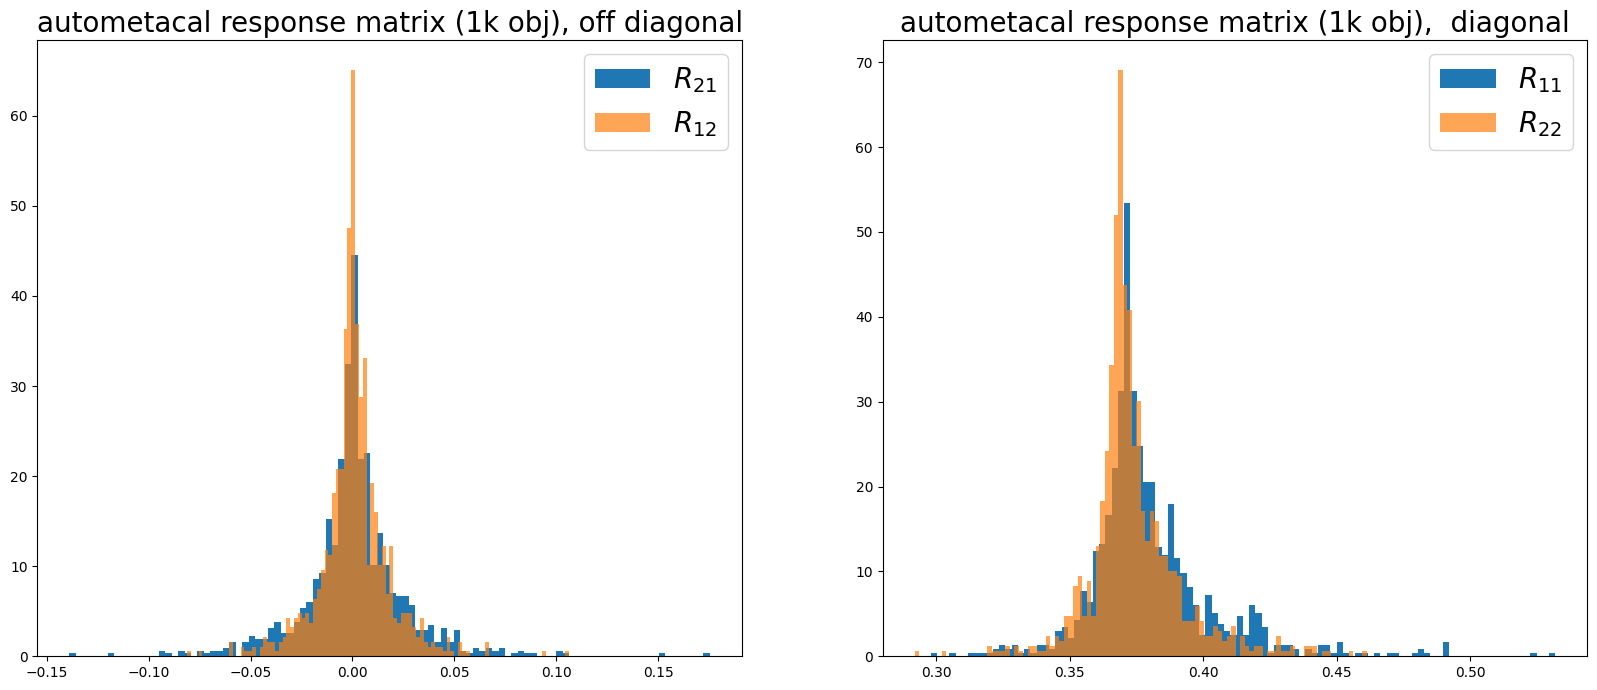

In [33]:
figure(figsize=(20,8))
subplot(122)
hist(R_auto[:,0,0].numpy()[:],bins=100,density=True,label="$R_{11}$");
hist(R_auto[:,1,1].numpy()[:],bins=100,density=True,label="$R_{22}$",alpha=.7);
title("autometacal response matrix (1k obj),  diagonal",fontsize=20)
legend(fontsize=20)
subplot(121)
hist(R_auto[:,1,0].numpy()[:],bins=100,label="$R_{21}$",density=True);
hist(R_auto[:,0,1].numpy()[:],bins=100,label="$R_{12}$",density=True,alpha=.7);
title("autometacal response matrix (1k obj), off diagonal",fontsize=20)
legend(fontsize=20)

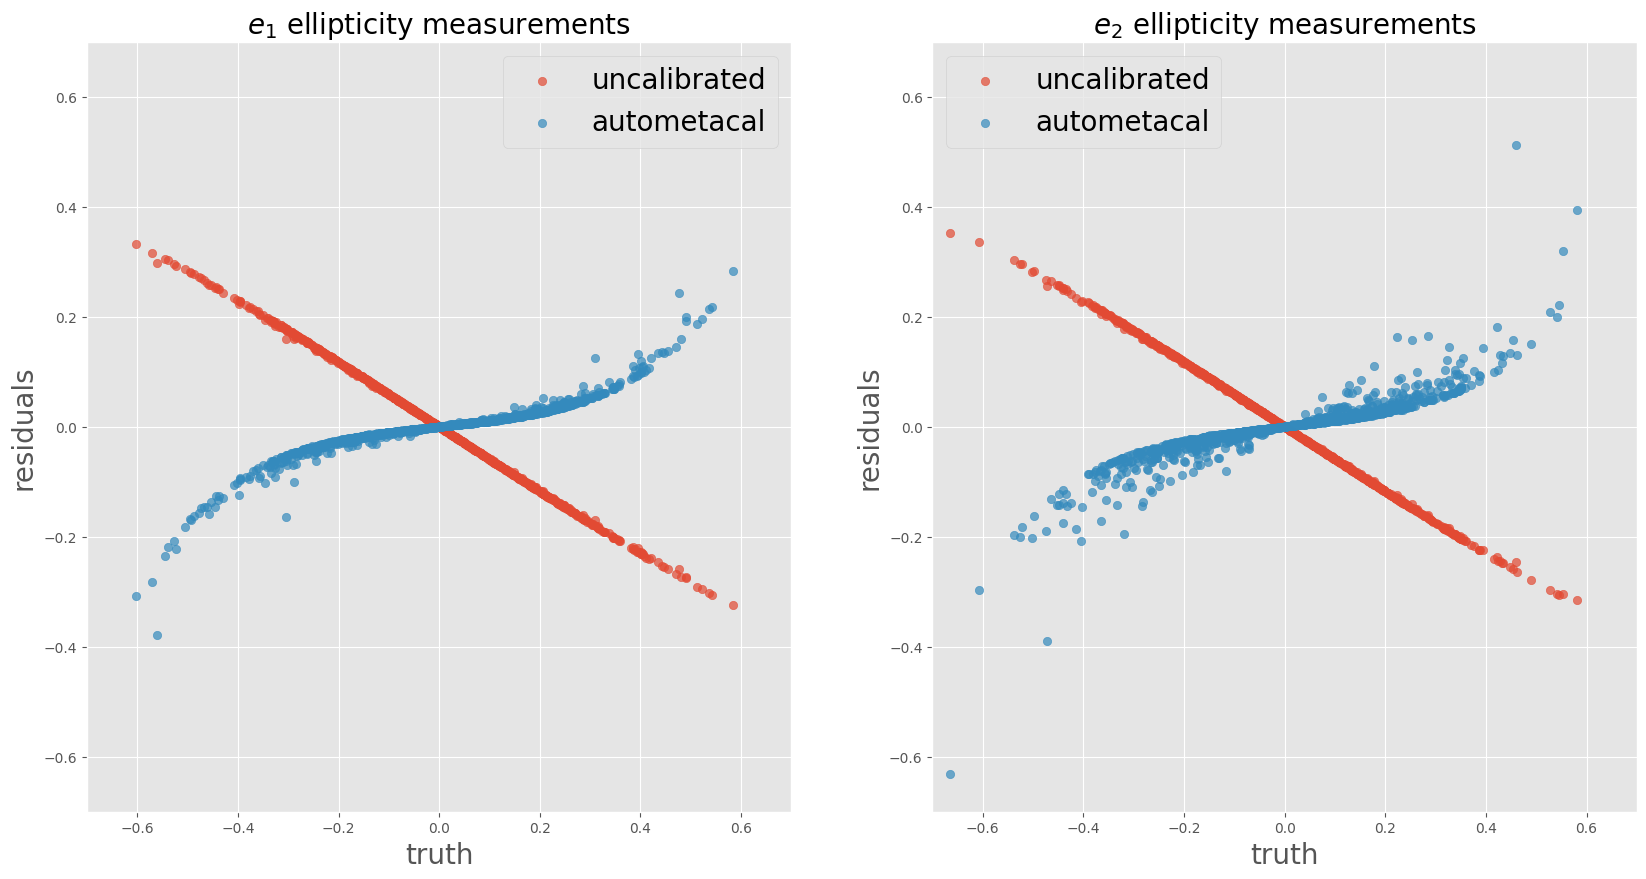

In [34]:
style.use('ggplot')
figure(figsize=(20,10))
subplot(121)
scatter(garray[:,0],e_auto[:,0]-garray[:,0],alpha=.7,label="uncalibrated")
scatter(garray[:,0],calibre_f[:,0,0]-garray[:,0],alpha=.7,label="autometacal")
title("$e_1$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel("residuals",fontsize=20)
legend(fontsize=20)
xlim(-0.7,0.7)
ylim(-0.7,0.7)
subplot(122)
scatter(garray[:,1],e_auto[:,1]-garray[:,1],alpha=.7,label="uncalibrated")
scatter(garray[:,1],calibre_f[:,1,0]-garray[:,1],alpha=.7,label="autometacal")
title("$e_2$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel("residuals",fontsize=20)
legend(fontsize=20)
xlim(-0.7,0.7)
ylim(-0.7,0.7)
savefig("linearity.png",bbox_inches="tight")

* *This is not an École Polytechnique ad.* :-)

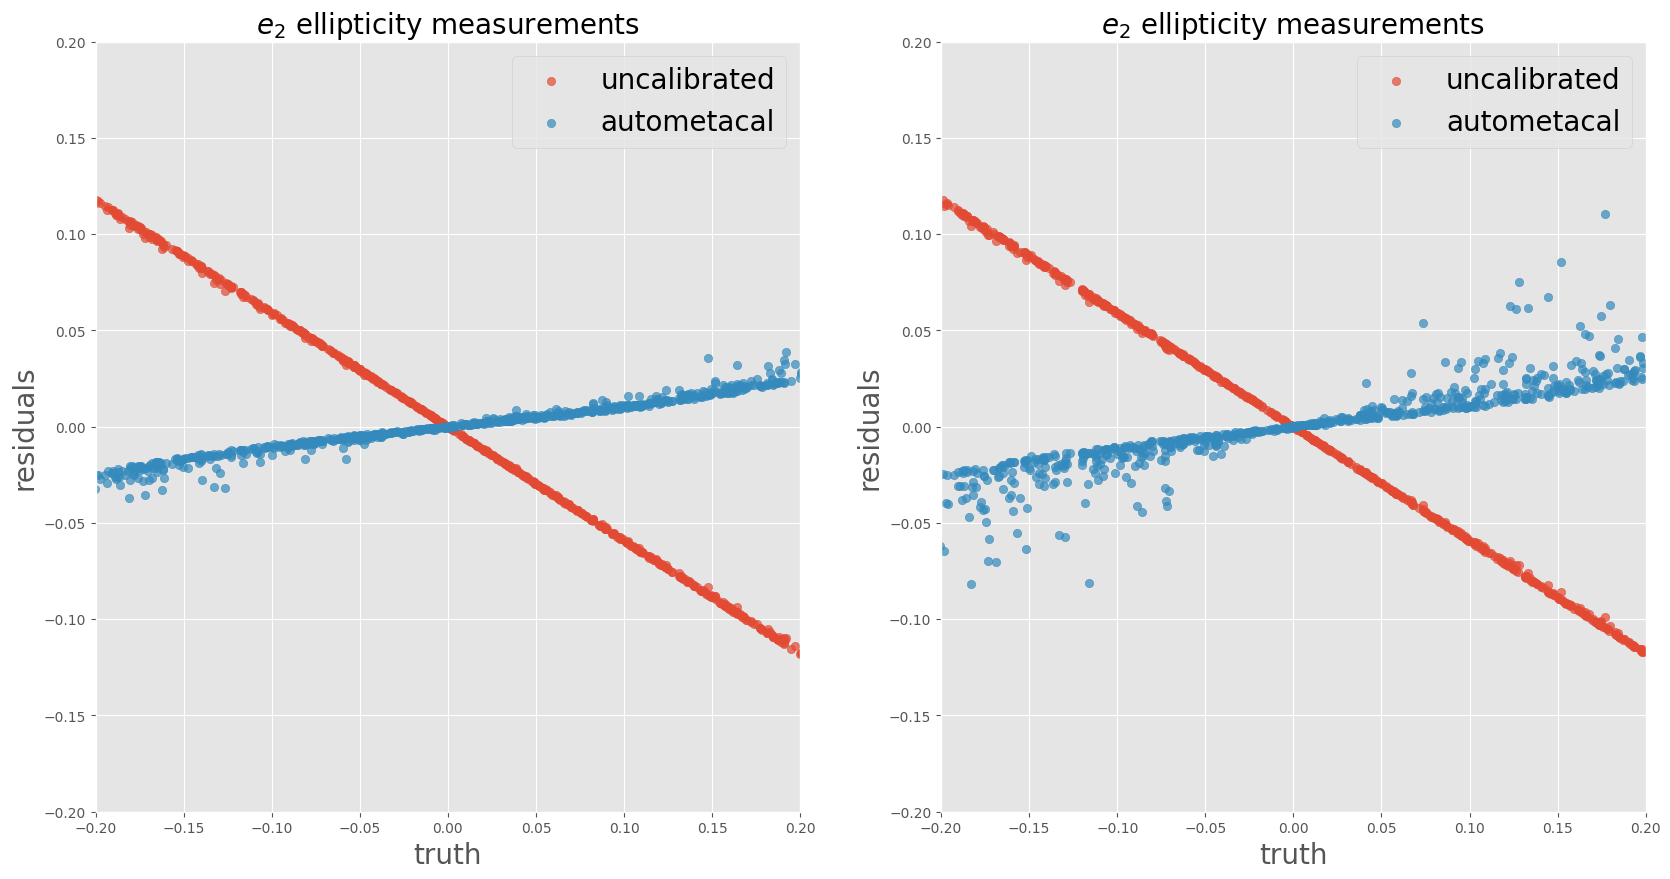

In [35]:
style.use('ggplot')
figure(figsize=(20,10))
box_size=.2
subplot(121)
scatter(garray[:,0],e_auto[:,0]-garray[:,0],alpha=.7,label="uncalibrated")
scatter(garray[:,0],calibre_f[:,0,0]-garray[:,0],alpha=.7,label="autometacal")
title("$e_2$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel("residuals",fontsize=20)
legend(fontsize=20)
xlim(-box_size,box_size)
ylim(-box_size,box_size)

subplot(122)
scatter(garray[:,1],e_auto[:,1]-garray[:,1],alpha=.7,label="uncalibrated")
scatter(garray[:,1],calibre_f[:,1,0]-garray[:,1],alpha=.7,label="autometacal")
title("$e_2$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel("residuals",fontsize=20)
legend(fontsize=20)
xlim(-box_size,box_size)
ylim(-box_size,box_size)
savefig("linearity_zoomed.png",bbox_inches="tight")


## Averaging the response comparison over many galaxies

In [36]:
e_finite_list = []
R_finite_list = []
for step in tqdm.tqdm(steps):
    e_finite, R_finite = get_metacal_response_finitediff(gal_images,
                                                         psf_images,
                                                         reconv_psf_image,
                                                         step=step,
                                                         method=get_ellipticities)
    e_finite_list.append(e_finite)
    R_finite_list.append(R_finite)
    
R_finite=np.array(R_finite_list)    
e_auto, R_auto = autometacal.get_metacal_response(gal_images,psf_images,reconv_psf_image,get_ellipticities)
calibre_f=tf.linalg.inv(R_auto[:]) @ tf.reshape(e_auto,[-1,2,1])

100%|██████████| 100/100 [04:07<00:00,  2.48s/it]


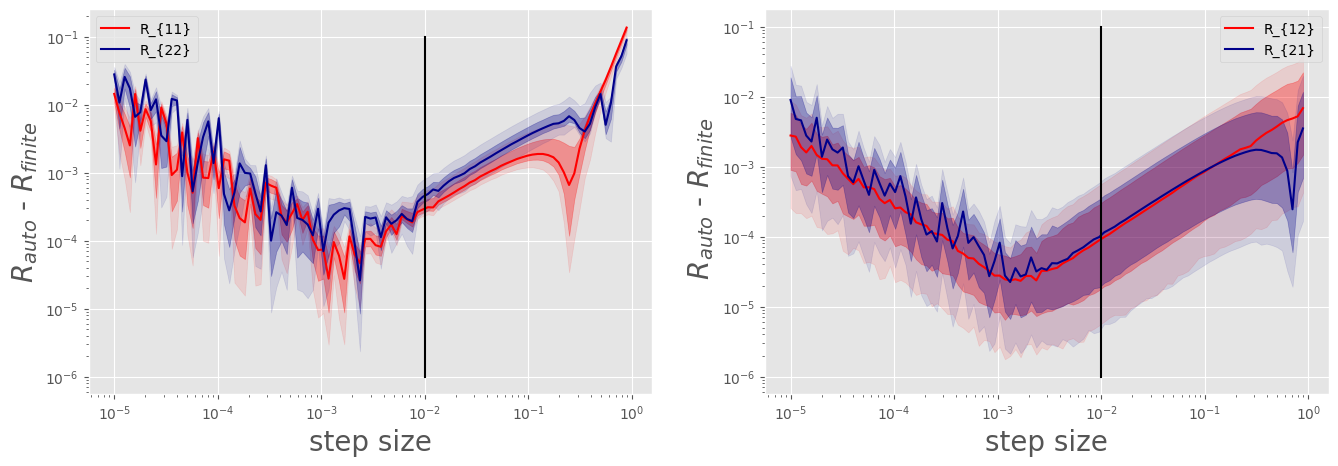

In [37]:
style.use('ggplot')
figure(figsize=(16,5))
subplot(121)

Yup00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),[95],axis=1)[0]
Ydn00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),[5],axis=1)[0]
fill_between(steps, Yup00,Ydn00,color='red',alpha=0.1)

Yup00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),[84],axis=1)[0]
Ydn00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),[16],axis=1)[0]
fill_between(steps, Yup00,Ydn00,color='red',alpha=0.3)

Yup11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),[95],axis=1)[0]
Ydn11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),[5],axis=1)[0]
fill_between(steps, Yup11,Ydn11,color='darkblue',alpha=0.1)

Yup11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),[84],axis=1)[0]
Ydn11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),[16],axis=1)[0]
fill_between(steps, Yup11,Ydn11,color='darkblue',alpha=0.3)


plot(steps,np.median(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),axis=1),label="R_{11}",color='red')
plot(steps,np.median(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),axis=1),label="R_{22}",color='darkblue')

plot([1e-2,1e-2],[1e-6,1e-1],'k-')
#ylim([1e-6,1e0])
xlabel('step size',fontsize=20)
ylabel('$R_{auto}$ - $R_{finite}$',fontsize=20)
legend()
xscale('log')
yscale('log')

subplot(122)

####CL95
Yup10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),[95],axis=1)[0]
Ydn10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),[5],axis=1)[0]
fill_between(steps, Yup10,Ydn10,color='red',alpha=0.1)
####CL68
Yup10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),[84],axis=1)[0]
Ydn10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),[16],axis=1)[0]
fill_between(steps, Yup10,Ydn10,color='red',alpha=0.3)


Yup01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),[95],axis=1)[0]
Ydn01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),[5],axis=1)[0]
fill_between(steps, Yup01,Ydn01,color='darkblue',alpha=0.1)

Yup01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),[84],axis=1)[0]
Ydn01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),[16],axis=1)[0]
fill_between(steps, Yup01,Ydn01,color='darkblue',alpha=0.3)

plot(steps,(np.median(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),axis=1)),label="R_{12}",color='red')
plot(steps,(np.median(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),axis=1)),label="R_{21}",color='darkblue')
plot([1e-2,1e-2],[1e-6,1e-1],'k-')
#ylim([1e-6,1e0])
xlabel('step size',fontsize=20)
ylabel(" $R_{auto}$ - $R_{finite}$",fontsize=20)
legend()
xscale('log')
yscale('log')
savefig('median_response.png',bbox_inches='tight')

## Higher Noise

10x noise

In [38]:
gal_images, psf_images = make_data(N=1000,
                                  psf_noise = psf_noise,
                                  img_noise = 10*img_noise,
                                  scale = scale,
                                  stamp_size = stamp_size,
                                  psf_fwhm = psf_fwhm,
                                  gal_hlr = gal_hlr,
                                  gal_g1=garray.T[0],gal_g2=garray.T[1])

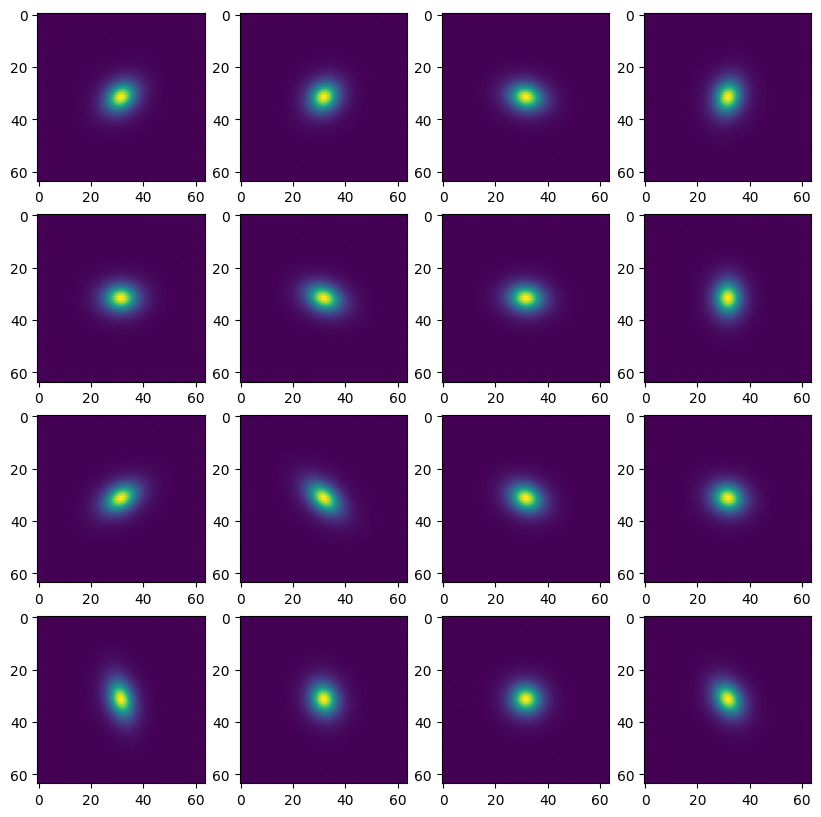

In [39]:
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i])

In [40]:
e_finite_list = []
R_finite_list = []
for step in tqdm.tqdm(steps):
    e_finite, R_finite = get_metacal_response_finitediff(gal_images,
                                                         psf_images,
                                                         reconv_psf_image,
                                                         step=step,
                                                         method=get_ellipticities)
    e_finite_list.append(e_finite)
    R_finite_list.append(R_finite)
R_finite = np.array(R_finite_list)

e_auto, R_auto = autometacal.get_metacal_response(gal_images,psf_images,reconv_psf_image,get_ellipticities)
calibre_f=tf.linalg.inv(R_auto[:]) @ tf.reshape(e_auto,[-1,2,1])

100%|██████████| 100/100 [04:10<00:00,  2.50s/it]


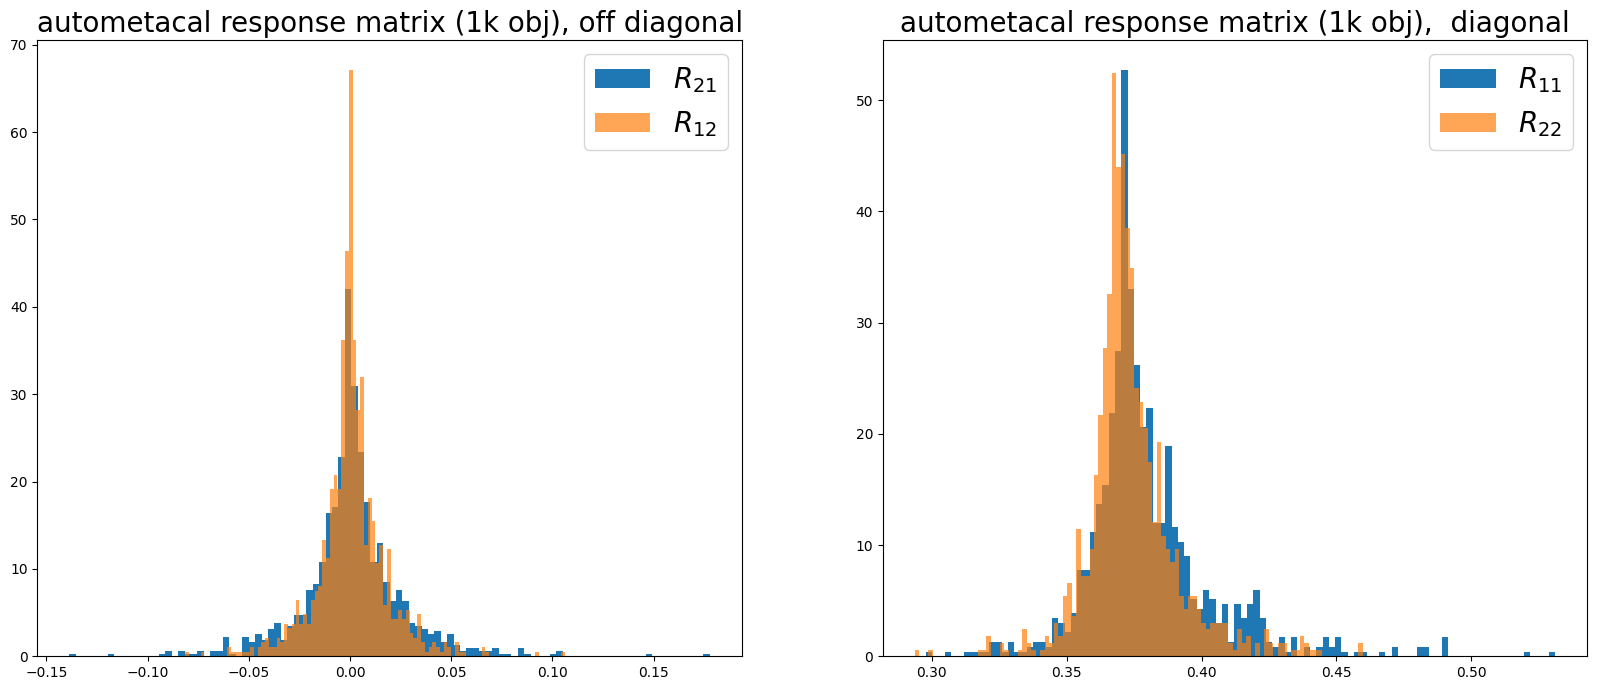

In [41]:
figure(figsize=(20,8))
subplot(122)
hist(R_auto[:,0,0].numpy()[:],bins=100,density=True,label="$R_{11}$");
hist(R_auto[:,1,1].numpy()[:],bins=100,density=True,label="$R_{22}$",alpha=.7);
title("autometacal response matrix (1k obj),  diagonal",fontsize=20)
legend(fontsize=20)
subplot(121)
hist(R_auto[:,1,0].numpy()[:],bins=100,label="$R_{21}$",density=True);
hist(R_auto[:,0,1].numpy()[:],bins=100,label="$R_{12}$",density=True,alpha=.7);
title("autometacal response matrix (1k obj), off diagonal",fontsize=20)
legend(fontsize=20)

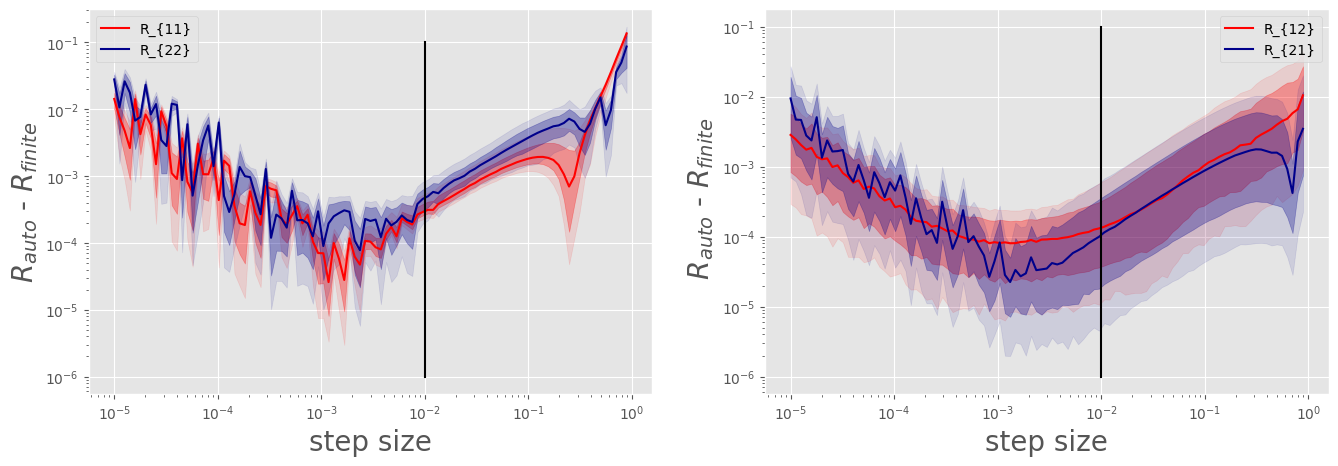

In [42]:
style.use('ggplot')
figure(figsize=(16,5))
subplot(121)

Yup00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),[95],axis=1)[0]
Ydn00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),[5],axis=1)[0]
fill_between(steps, Yup00,Ydn00,color='red',alpha=0.1)

Yup00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),[84],axis=1)[0]
Ydn00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),[16],axis=1)[0]
fill_between(steps, Yup00,Ydn00,color='red',alpha=0.3)

Yup11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),[95],axis=1)[0]
Ydn11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),[5],axis=1)[0]
fill_between(steps, Yup11,Ydn11,color='darkblue',alpha=0.1)

Yup11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),[84],axis=1)[0]
Ydn11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),[16],axis=1)[0]
fill_between(steps, Yup11,Ydn11,color='darkblue',alpha=0.3)


plot(steps,np.median(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),axis=1),label="R_{11}",color='red')
plot(steps,np.median(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),axis=1),label="R_{22}",color='darkblue')

plot([1e-2,1e-2],[1e-6,1e-1],'k-')
#ylim([1e-6,1e0])
xlabel('step size',fontsize=20)
ylabel('$R_{auto}$ - $R_{finite}$',fontsize=20)
legend()
xscale('log')
yscale('log')

subplot(122)

####CL95
Yup10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),[95],axis=1)[0]
Ydn10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),[5],axis=1)[0]
fill_between(steps, Yup10,Ydn10,color='red',alpha=0.1)
####CL68
Yup10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),[84],axis=1)[0]
Ydn10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),[16],axis=1)[0]
fill_between(steps, Yup10,Ydn10,color='red',alpha=0.3)


Yup01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),[95],axis=1)[0]
Ydn01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),[5],axis=1)[0]
fill_between(steps, Yup01,Ydn01,color='darkblue',alpha=0.1)

Yup01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),[84],axis=1)[0]
Ydn01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),[16],axis=1)[0]
fill_between(steps, Yup01,Ydn01,color='darkblue',alpha=0.3)

plot(steps,(np.median(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),axis=1)),label="R_{12}",color='red')
plot(steps,(np.median(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),axis=1)),label="R_{21}",color='darkblue')
plot([1e-2,1e-2],[1e-6,1e-1],'k-')
#ylim([1e-6,1e0])
xlabel('step size',fontsize=20)
ylabel(" $R_{auto}$ - $R_{finite}$",fontsize=20)
legend()
xscale('log')
yscale('log')
savefig('median_response_10x_noise.png',bbox_inches='tight')

100x noise

In [43]:
gal_images, psf_images = make_data(N=1000,
                                  psf_noise = psf_noise,
                                  img_noise = 20*img_noise,
                                  scale = scale,
                                  stamp_size = stamp_size,
                                  psf_fwhm = psf_fwhm,
                                  gal_hlr = gal_hlr,
                                  gal_g1=garray.T[0],gal_g2=garray.T[1])

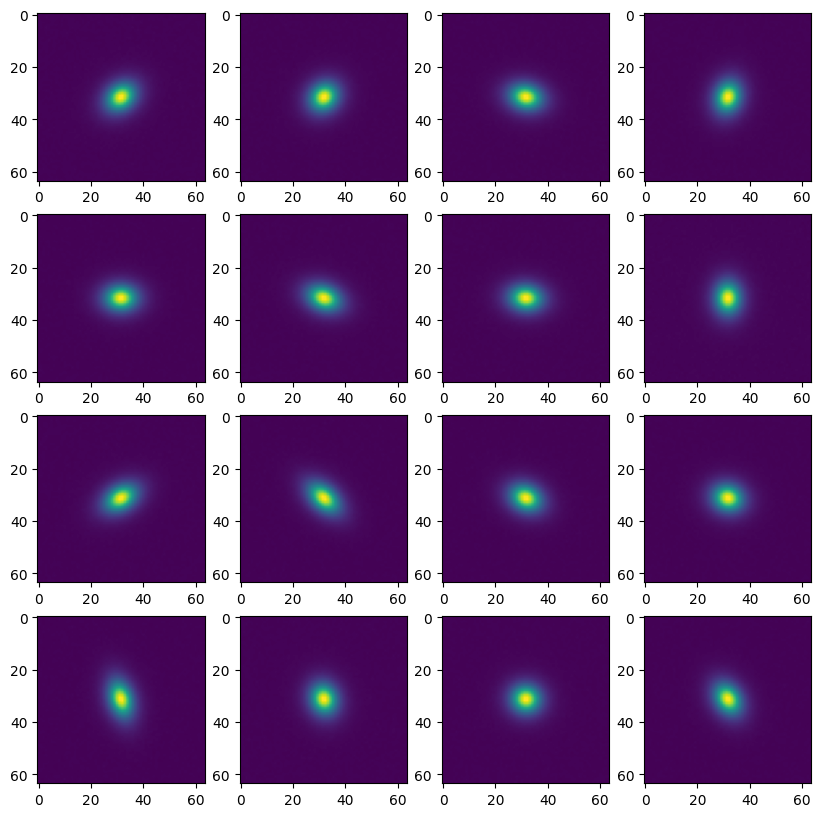

In [44]:
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i])

In [45]:
e_finite_list = []
R_finite_list = []
for step in tqdm.tqdm(steps):
    e_finite, R_finite = get_metacal_response_finitediff(gal_images,
                                                         psf_images,
                                                         reconv_psf_image,
                                                         step=step,
                                                         method=get_ellipticities)
    e_finite_list.append(e_finite)
    R_finite_list.append(R_finite)
R_finite = np.array(R_finite_list)

e_auto, R_auto = autometacal.get_metacal_response(gal_images,psf_images,reconv_psf_image,get_ellipticities)
calibre_f=tf.linalg.inv(R_auto[:]) @ tf.reshape(e_auto,[-1,2,1])

100%|██████████| 100/100 [04:09<00:00,  2.50s/it]


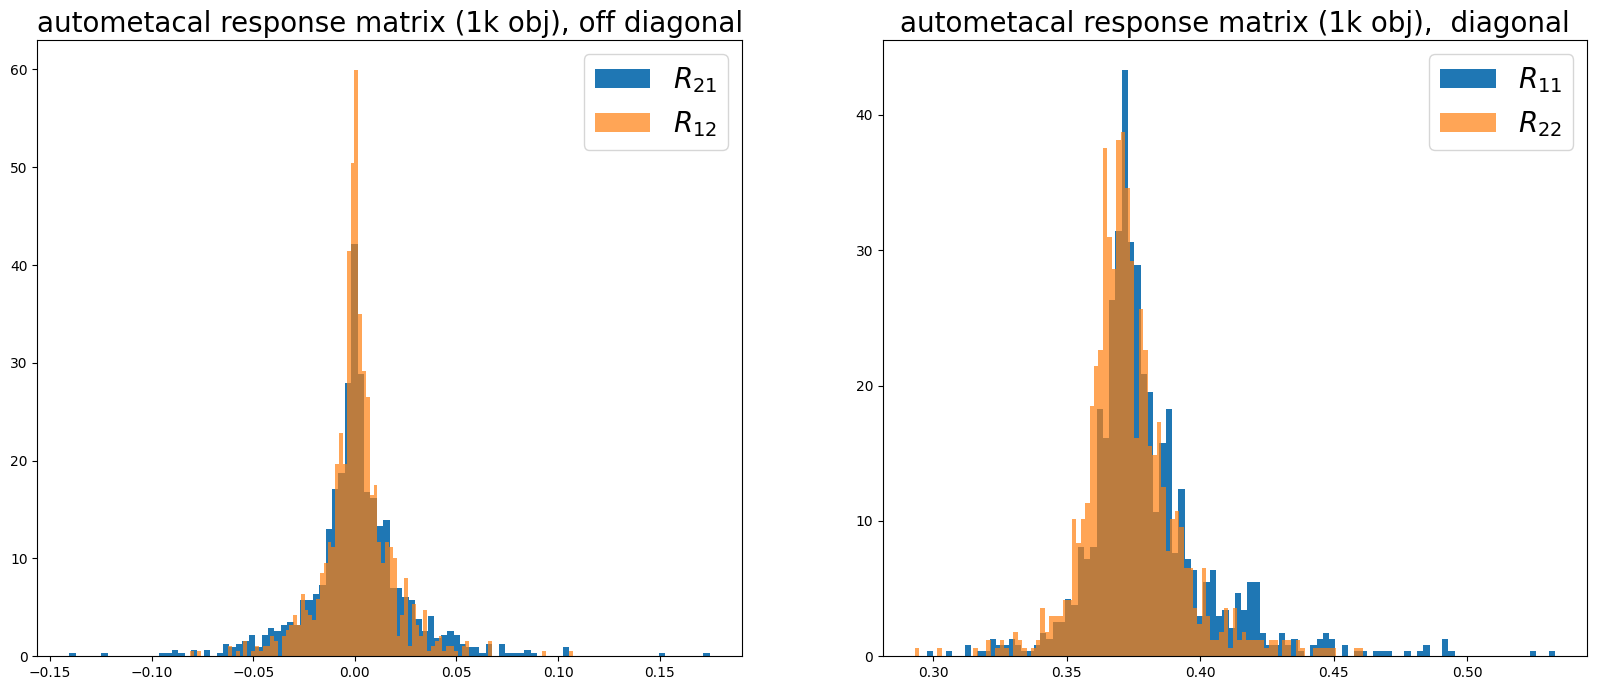

In [46]:
figure(figsize=(20,8))
subplot(122)
hist(R_auto[:,0,0].numpy()[:],bins=100,density=True,label="$R_{11}$");
hist(R_auto[:,1,1].numpy()[:],bins=100,density=True,label="$R_{22}$",alpha=.7);
title("autometacal response matrix (1k obj),  diagonal",fontsize=20)
legend(fontsize=20)
subplot(121)
hist(R_auto[:,1,0].numpy()[:],bins=100,label="$R_{21}$",density=True);
hist(R_auto[:,0,1].numpy()[:],bins=100,label="$R_{12}$",density=True,alpha=.7);
title("autometacal response matrix (1k obj), off diagonal",fontsize=20)
legend(fontsize=20)

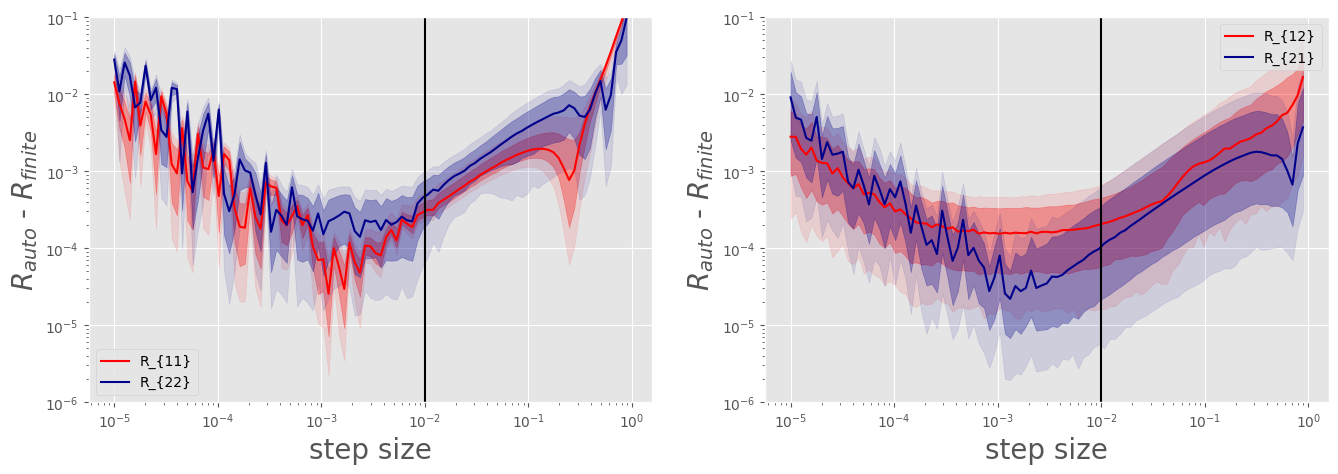

In [47]:
style.use('ggplot')
R_finite=np.array(R_finite_list)
figure(figsize=(16,5))
subplot(121)

Yup00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),[95],axis=1)[0]
Ydn00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),[5],axis=1)[0]
fill_between(steps, Yup00,Ydn00,color='red',alpha=0.1)

Yup00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),[84],axis=1)[0]
Ydn00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),[16],axis=1)[0]
fill_between(steps, Yup00,Ydn00,color='red',alpha=0.3)

Yup11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),[95],axis=1)[0]
Ydn11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),[5],axis=1)[0]
fill_between(steps, Yup11,Ydn11,color='darkblue',alpha=0.1)

Yup11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),[84],axis=1)[0]
Ydn11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),[16],axis=1)[0]
fill_between(steps, Yup11,Ydn11,color='darkblue',alpha=0.3)


plot(steps,np.median(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),axis=1),label="R_{11}",color='red')
plot(steps,np.median(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),axis=1),label="R_{22}",color='darkblue')
plot([1e-2,1e-2],[1e-6,1e-1],'k-')

ylim([1e-6,1e-1])
xlabel('step size',fontsize=20)
ylabel('$R_{auto}$ - $R_{finite}$',fontsize=20)
legend()
xscale('log')
yscale('log')

subplot(122)

####CL95
Yup10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),[95],axis=1)[0]
Ydn10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),[5],axis=1)[0]
fill_between(steps, Yup10,Ydn10,color='red',alpha=0.1)
####CL68
Yup10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),[84],axis=1)[0]
Ydn10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),[16],axis=1)[0]
fill_between(steps, Yup10,Ydn10,color='red',alpha=0.3)

Yup01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),[95],axis=1)[0]
Ydn01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),[5],axis=1)[0]
fill_between(steps, Yup01,Ydn01,color='darkblue',alpha=0.1)

Yup01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),[84],axis=1)[0]
Ydn01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),[16],axis=1)[0]
fill_between(steps, Yup01,Ydn01,color='darkblue',alpha=0.3)

plot(steps,(np.median(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),axis=1)),label="R_{12}",color='red')
plot(steps,(np.median(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),axis=1)),label="R_{21}",color='darkblue')
plot([1e-2,1e-2],[1e-6,1e-1],'k-')

ylim([1e-6,1e-1])
xlabel('step size',fontsize=20)
ylabel("$R_{auto}$ - $R_{finite}$",fontsize=20)
legend()
xscale('log')
yscale('log')
savefig('median_response_20x_noise.png',bbox_inches='tight')